# Age and Gender Prediction

The <a href="https://susanqq.github.io/UTKFace/" style="color:#D18358"> UTKFace dataset </a> is a large-scale face dataset consisting of over 20,000 images. The images cover a wide range of ages and races and include both males and females. 

Using this dataset, I will be attempting to create a model capable of predicting the age and gender of an individual. I will be using part one of the cropped variations of the images, of which there are almost 10,000. However, I will only be using the first 8000 of these images due to memory limitations.

## 1. Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## 2. Loading Data

In [3]:
images = []
ages = []
genders = []

for i in os.listdir('../input/utkface-new/crop_part1/')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('../input/utkface-new/crop_part1/' + i))

In [4]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df

,Images,Ages,Genders
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,76,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,18,1
...,...,...,...
7995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,0
7996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28,0
7997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10,0
7998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,8,1


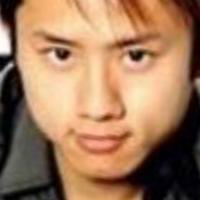

26 0


In [5]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0])

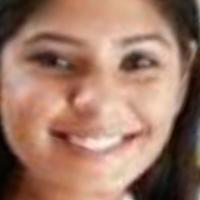

21 1


In [6]:
display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1])

So 0 corresponds to male, 1 corresponds to female.

## 3. Visualising and Preparing Data

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ages', ylabel='Density'>

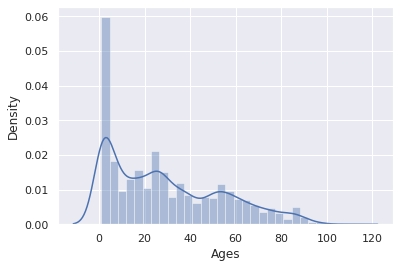

In [7]:
sns.set_theme()
sns.distplot(df['Ages'],kde=True, bins=30)

Too many faces of people between 0 and 4 years old. The model would fit too well to these ages and not enough to the other ages. To resolve this I'm only going to include a third of the images between these ages.

In [8]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ages', ylabel='Density'>

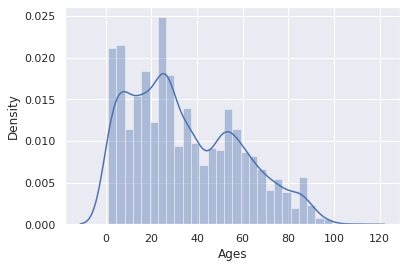

In [9]:
sns.distplot(df['Ages'],kde=True, bins=30)

This looks much better! The dataframe is more representative of the population now. However, there aren't many images of people over 80, which would cause the model to not train well enough on those ages. It's best to just remove over 80s and only have a model that can predict the ages of people under 80.

In [15]:
df = df[df['Ages'] < 80]

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ages', ylabel='Density'>

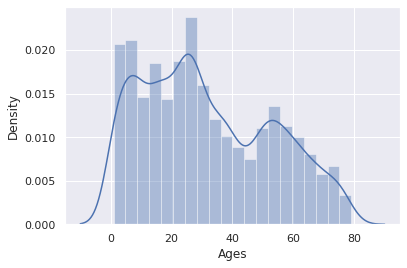

In [16]:
sns.distplot(df['Ages'],kde=True, bins=20)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Genders', ylabel='count'>

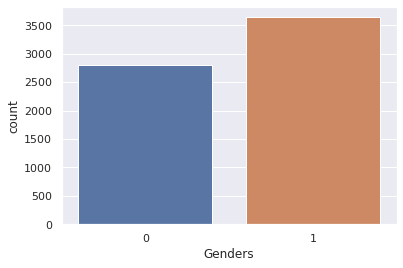

In [17]:
sns.countplot(df['Genders'])

In [20]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)
x = np.array(x)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## 4. Train Test Split

In [21]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

## 5. Creating the Models

I will create two individual models - one to predict age and one to predict gender. The age model should be capable of returning continuous values which I will round to the nearest integer, and the gender model should return a binary result.

In [22]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam(lr=0.0001))

genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

genmodel.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(lr=0.0001),
             metrics=['accuracy'])

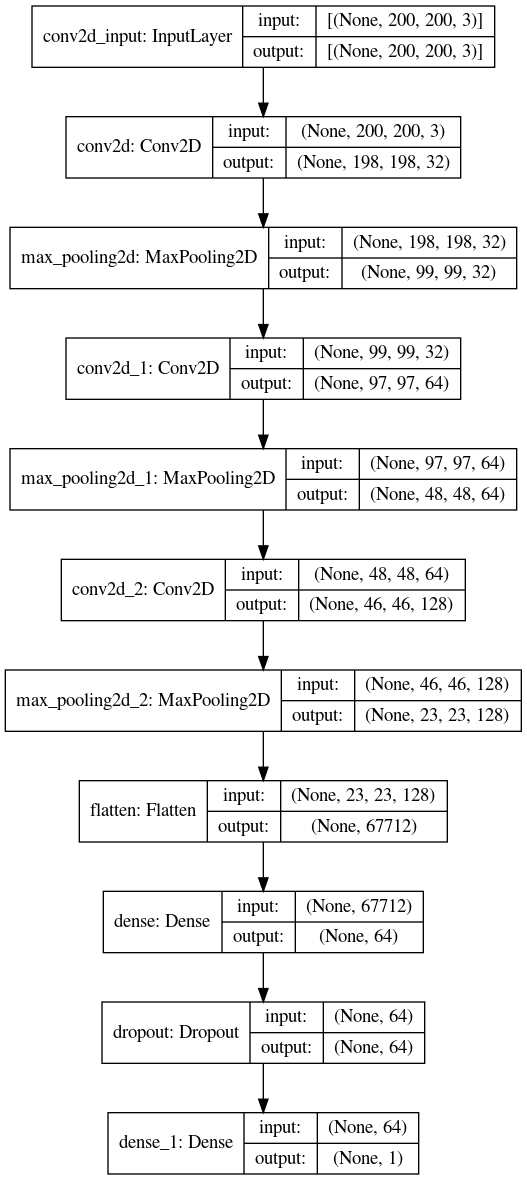

In [29]:
from keras.utils import plot_model
plot_model(agemodel, show_shapes=True)

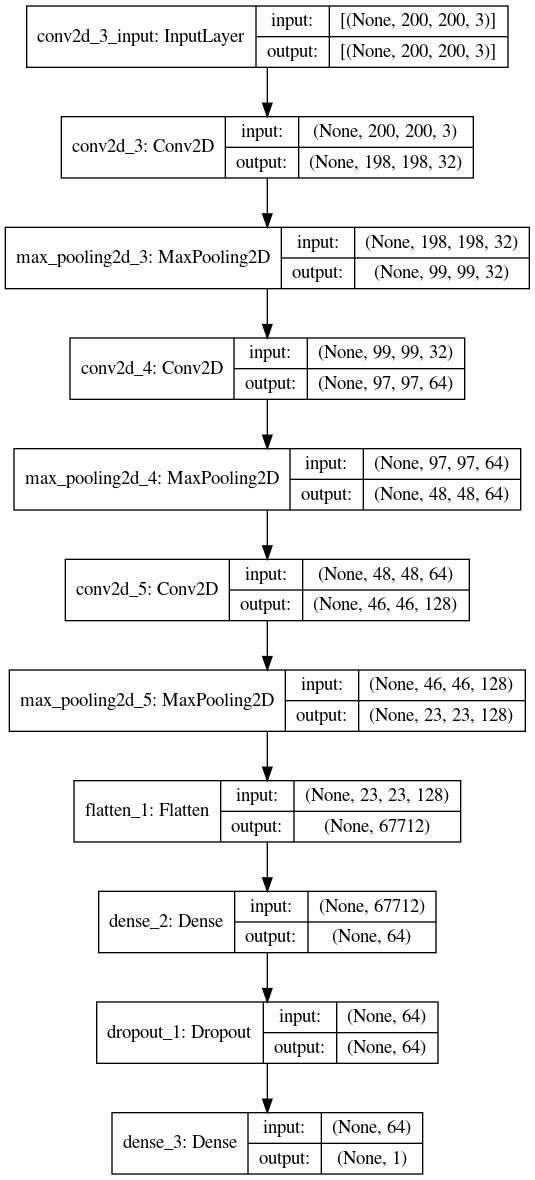

In [30]:
plot_model(genmodel, show_shapes=True)

## 6. Training the Models

In [23]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test1 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

history1 = agemodel.fit(train1, epochs=15, shuffle=True, validation_data=test1)

Epoch 1/15
161/161 [==============================] - 256s 2s/step - loss: 671.1407 - val_loss: 475.5667
Epoch 2/15
161/161 [==============================] - 257s 2s/step - loss: 501.0814 - val_loss: 408.3664
Epoch 3/15
161/161 [==============================] - 257s 2s/step - loss: 439.3352 - val_loss: 328.2512
Epoch 4/15
161/161 [==============================] - 255s 2s/step - loss: 393.0231 - val_loss: 298.7552
Epoch 5/15
161/161 [==============================] - 255s 2s/step - loss: 370.9174 - val_loss: 304.4151
Epoch 6/15
161/161 [==============================] - 258s 2s/step - loss: 363.2023 - val_loss: 338.9305
Epoch 7/15
161/161 [==============================] - 262s 2s/step - loss: 338.7381 - val_loss: 264.8245
Epoch 8/15
161/161 [==============================] - 266s 2s/step - loss: 340.7778 - val_loss: 240.5175
Epoch 9/15
161/161 [==============================] - 273s 2s/step - loss: 326.2815 - val_loss: 232.6982
Epoch 10/15
161/161 [==============================] - 

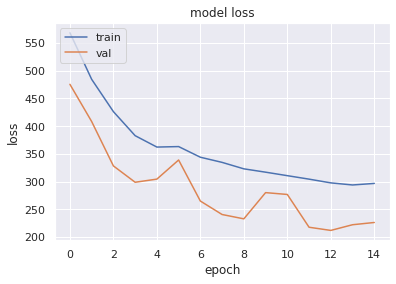

In [24]:
import matplotlib.pyplot as plt
history = history1
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=64)

history2 = genmodel.fit(train2, epochs=15, shuffle=True, validation_data=test2)

Epoch 1/15
81/81 [==============================] - 265s 3s/step - loss: 0.6725 - accuracy: 0.5738 - val_loss: 0.5749 - val_accuracy: 0.7174
Epoch 2/15
81/81 [==============================] - 260s 3s/step - loss: 0.6011 - accuracy: 0.6804 - val_loss: 0.5357 - val_accuracy: 0.7430
Epoch 3/15
81/81 [==============================] - 264s 3s/step - loss: 0.5631 - accuracy: 0.7244 - val_loss: 0.5023 - val_accuracy: 0.7725
Epoch 4/15
81/81 [==============================] - 265s 3s/step - loss: 0.5352 - accuracy: 0.7387 - val_loss: 0.4806 - val_accuracy: 0.7873
Epoch 5/15
81/81 [==============================] - 267s 3s/step - loss: 0.4998 - accuracy: 0.7613 - val_loss: 0.4810 - val_accuracy: 0.7655
Epoch 6/15
81/81 [==============================] - 266s 3s/step - loss: 0.4906 - accuracy: 0.7707 - val_loss: 0.4445 - val_accuracy: 0.7919
Epoch 7/15
81/81 [==============================] - 264s 3s/step - loss: 0.4633 - accuracy: 0.7874 - val_loss: 0.4512 - val_accuracy: 0.7880
Epoch 8/15
81

In [26]:
agemodel.save('agemodel.h5')


In [27]:
agemodel.save('genmodel.h5')

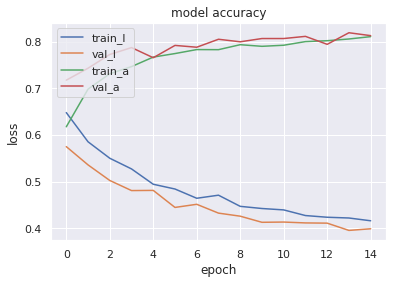

In [28]:
history = history2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_l', 'val_l', 'train_a','val_a'], loc='upper left')
plt.show()

In [33]:
 print("Evaluation:")
evaluation_test = agemodel.evaluate(test1, steps=len(test1))
print("%s%.2f  "% ("Test Loss     : ", evaluation_test))

Evaluation:
41/41 [==============================] - 18s 431ms/step - loss: 226.1191
Test Loss     : 226.12  


In [36]:
 print("Evaluation:")
evaluation_test = genmodel.evaluate(test1, steps=len(test2))
print("%s%.2f  "% ("Test Loss     : ", evaluation_test[0]))
print("%s%.2f%s"% ("Test Accuracy : ", evaluation_test[1]*100, "%"))

Evaluation:
21/21 [==============================] - 9s 422ms/step - loss: 1.9274 - accuracy: 0.0238
Test Loss     : 1.93  
Test Accuracy : 2.38%


In [47]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
actual = test2.y
pred = genmodel.predict(test2.x)
pred_probs = pred.copy()
pred[pred <= 0.5] = 0
pred[pred > 0.5] = 1
print(classification_report(actual, pred, target_names = ['Male','Female']))

              precision    recall  f1-score   support

        Male       0.67      0.93      0.78       560
      Female       0.92      0.65      0.76       728

    accuracy                           0.77      1288
   macro avg       0.79      0.79      0.77      1288
weighted avg       0.81      0.77      0.77      1288



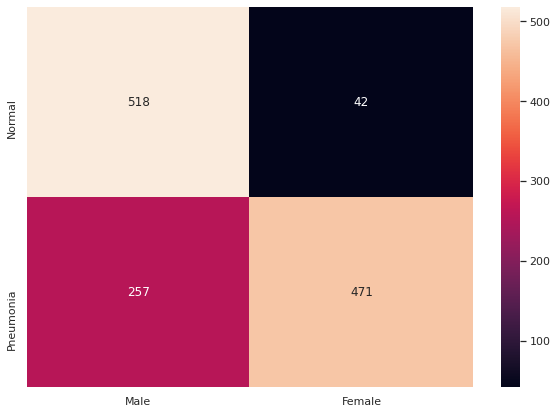

In [49]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(actual, pred), annot=True,fmt='.4g', 
            xticklabels=['Male','Female'], yticklabels=['Normal','Pneumonia'])
plt.show()